In [1]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt

In [2]:
matplotlib.rcParams['figure.figsize'] = (10.0, 8.0)

In [3]:
import preprocessor
from Registerer import Registerer
import SimpleITK as sitk
import ndreg
import numpy as np
from intern.remote.boss import BossRemote
from intern.resource.boss.resource import *
import sys
sys.path.append('../pylddmm/')

In [4]:
def create_channel_resource(rmt, chan_name, coll_name, exp_name, type='image', base_resolution=0, sources=[], datatype='uint16', new_channel=True):
    channel_resource = ChannelResource(chan_name, coll_name, exp_name, type=type, base_resolution=base_resolution, sources=sources, datatype=datatype)
    if new_channel: 
        new_rsc = rmt.create_project(channel_resource)
        return new_rsc

    return channel_resource

def upload_to_boss(rmt, data, channel_resource, resolution=0):
    Z_LOC = 0
    size = data.shape
    for i in range(0, data.shape[Z_LOC], 16):
        last_z = i+16
        if last_z > data.shape[Z_LOC]:
            last_z = data.shape[Z_LOC]
        print(resolution, [0, size[2]], [0, size[1]], [i, last_z])
        rmt.create_cutout(channel_resource, resolution, [0, size[2]], [0, size[1]], [i, last_z], np.asarray(data[i:last_z,:,:], order='C'))

def download_ara(rmt, resolution, type='average'):
    if resolution not in [10, 25, 50, 100]:
        print('Please provide a resolution that is among the following: 10, 25, 50, 100')
        return
    REFERENCE_COLLECTION = 'ara_2016'
    REFERENCE_EXPERIMENT = 'sagittal_{}um'.format(resolution)
    REFERENCE_COORDINATE_FRAME = 'ara_2016_{}um'.format(resolution) 
    REFERENCE_CHANNEL = '{}_{}um'.format(type, resolution)

    refImg = download_image(rmt, REFERENCE_COLLECTION, REFERENCE_EXPERIMENT, REFERENCE_CHANNEL, ara_res=resolution)

    return refImg

def download_image(rmt, collection, experiment, channel, res=0, isotropic=True, ara_res=None):
    (exp_resource, coord_resource, channel_resource) = ndreg.setup_channel_boss(rmt, collection, experiment, channel)
    img = ndreg.imgDownload_boss(rmt, channel_resource, coord_resource, resolution=res, isotropic=isotropic)
    return img



## Load data

In [5]:
coll = 'ailey-dev'
exp = '170119_Insula_grCOMET_244_08-39-35'
chan = 'Ch0'
rmt = BossRemote(cfg_file_or_dict='../.intern/intern.cfg')

In [6]:
img = download_image(rmt, coll, exp, chan, res=3)
img_np = sitk.GetArrayFromImage(img)
atlas = download_ara(rmt, 50)

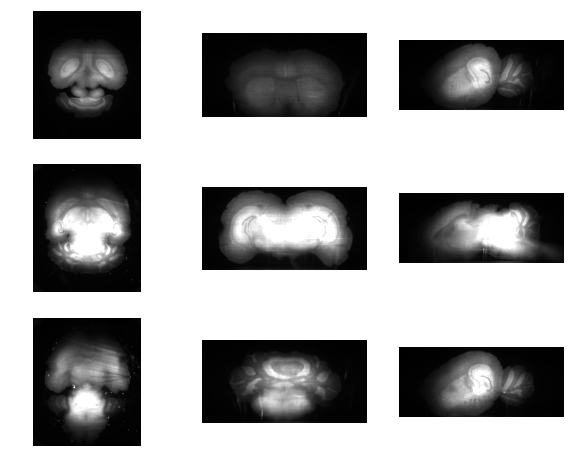

In [7]:
ndreg.imgShow(img, vmax=15000)

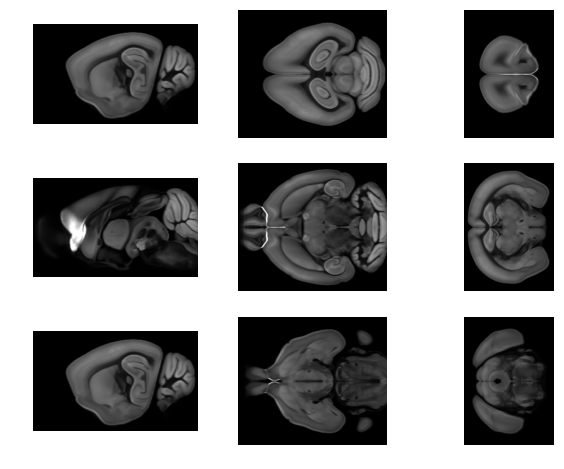

In [8]:
ndreg.imgShow(atlas)

## remove streaks

In [9]:
img_sf = preprocessor.remove_streaks(img)

/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:1: ComplexWarning: Casting complex values to real discards the imaginary part
  """Entry point for launching an IPython kernel.


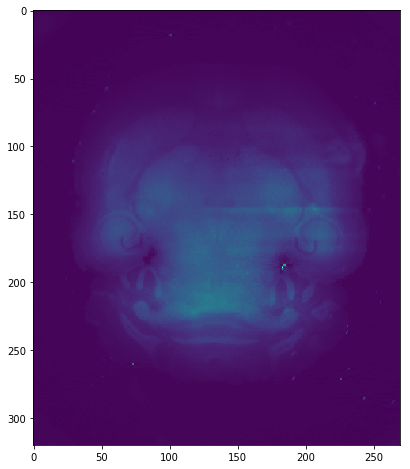

In [10]:
plt.imshow(img_sf.astype('float')[80,:,:])
plt.show()

## Remove circle

In [11]:
# img_no_circle = preprocessor.remove_circle(new_img.astype('uint16'))

In [12]:
# plt.imshow(img_no_circle[80,:,:], vmax=10000)
# plt.show()

## Create mask

In [13]:
mask = preprocessor.create_mask(img_sf.astype('uint16'), use_triangle=True)

/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:1: ComplexWarning: Casting complex values to real discards the imaginary part
  """Entry point for launching an IPython kernel.


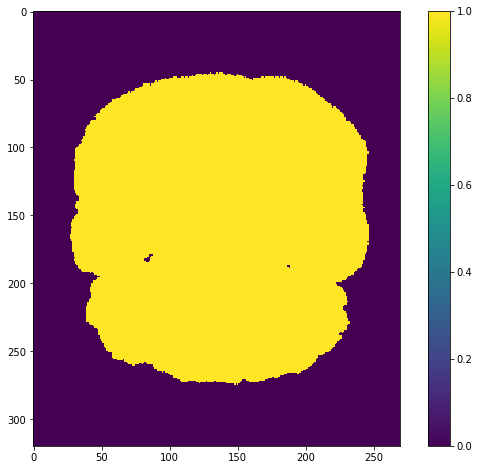

In [14]:
plt.imshow(mask[80,:,:])
plt.colorbar()
plt.show()

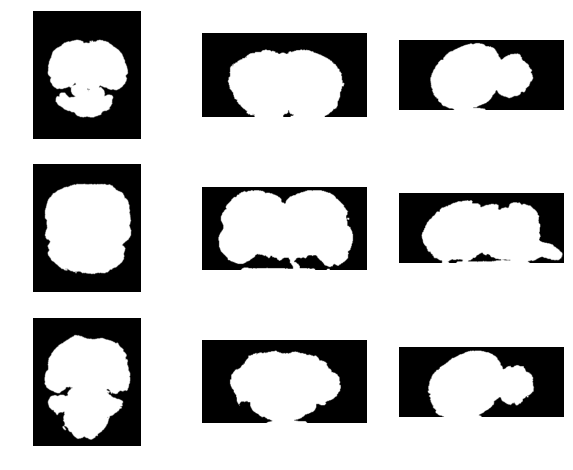

In [15]:
mask_sitk = sitk.GetImageFromArray(mask)
mask_sitk.CopyInformation(img)
ndreg.imgShow(mask_sitk)

### Step 6: Correct Bias field

In [27]:
img_bias_corrected = preprocessor.correct_bias_field(img, mask=mask_sitk, scale=0.25, spline_order=3, 
                                                     niters=[50, 50, 50], num_control_pts=[6, 6, 5])

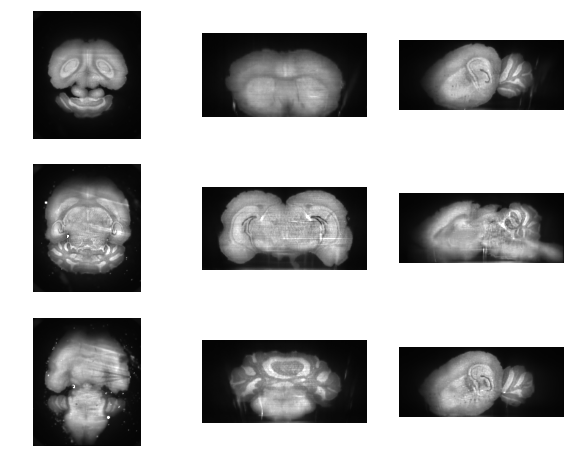

In [28]:
ndreg.imgShow(img_bias_corrected, vmax=10000)

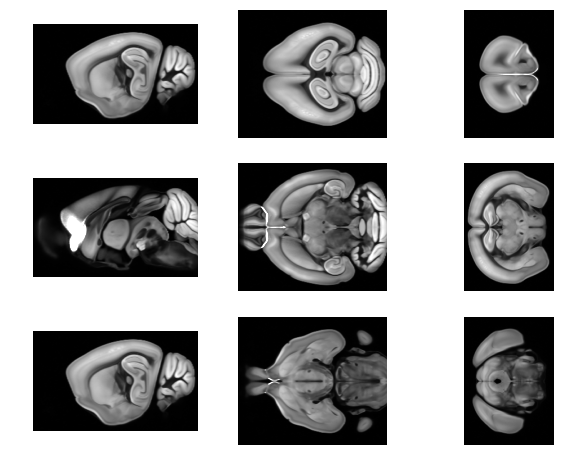

In [26]:
ndreg.imgShow(atlas, vmax=300)

## Registration

In [27]:
registerer = Registerer(atlas, img_bias_corrected, "PIR", "LPI")
# registerer = Registerer(atlas, img, "ASR", "ASR")

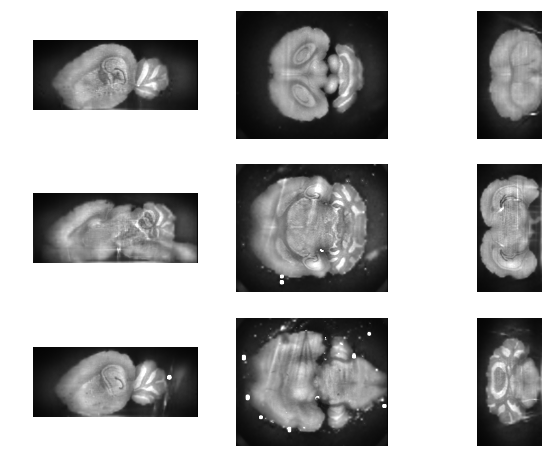

In [28]:
ndreg.imgShow(ndreg.imgReorient(img_bias_corrected, "LPI", "PIR"), vmax=11000)

### Perform affine registration

In [29]:
atlas_affine = registerer.register_affine(0.050, iterations=5000.0, resolutions=8.0, use_mi=True)

RuntimeError: Exception thrown in SimpleITK ElastixImageFilter_Execute: /SimpleElastix/Code/Elastix/src/sitkElastixImageFilterImpl.cxx:259:
sitk::ERROR: 
itk::ExceptionObject (0x85f1e60)
Location: "unknown" 
File: /build/Elastix/Core/Main/elxElastixFilter.hxx
Line: 248
Description: itk::ERROR: Self(0x7b6e020): Internal elastix error: See elastix log (use LogToConsoleOn() or LogToFileOn()).



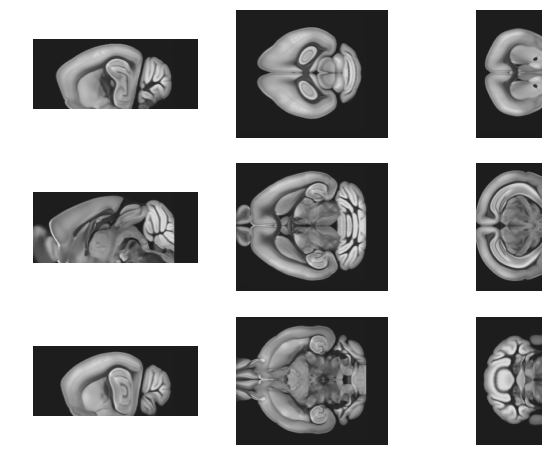

In [33]:
ndreg.imgShow(atlas_affine)

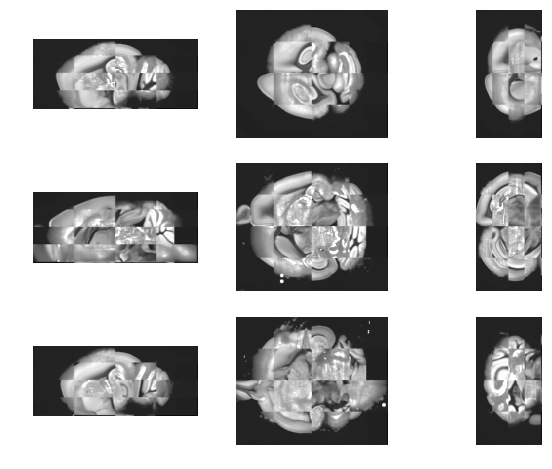

In [34]:
ndreg.imgShow(ndreg.imgChecker(registerer.target_ds, atlas_affine, useHM=True), vmax=1)

### if you have fiducials, evaluate error

In [35]:
# mse_affine = registerer.evaluate_affine_registration('../Manual Fiducials/Control9/average_template_10-landmarks.fcsv', 
#                                  '../Manual Fiducials/Control9/Control9Auto-landmarks.fcsv', 
#                                  0.01/10.0, 0.00516/1.0, "ASL", "RAS")

In [36]:
# np.mean(mse_affine)

In [37]:
# np.median(mse_affine)


Step 0: alpha=0.02, beta=0.05, scale=0.0625
	E, E_velocity, E_rate, E_image (E_image %), LearningRate
0.	-5.50165e+08, 161.184, 0, -5.50166e+08 (99.5441%), 2.750000e-04
1.	-5.61581e+08, 457.991, 0, -5.61581e+08 (98.227%), 3.025000e-04
2.	-5.73556e+08, 789.882, 0, -5.73557e+08 (96.8453%), 3.327500e-04
3.	-5.79276e+08, 1203.17, 0, -5.79278e+08 (96.1853%), 3.660250e-04
4.	-5.80865e+08, 1224.53, 0, -5.80866e+08 (96.0021%), 1.006569e-04
5.	-5.81486e+08, 1225.31, 0, -5.81487e+08 (95.9304%), 2.768064e-05
6.	-5.82583e+08, 1228.1, 0, -5.82584e+08 (95.8038%), 7.612176e-06
7.	-5.83615e+08, 1230.03, 0, -5.83616e+08 (95.6848%), 8.373394e-06
8.	-5.85873e+08, 1233.67, 0, -5.85874e+08 (95.4242%), 9.210733e-06
9.	-5.87223e+08, 1235.43, 0, -5.87224e+08 (95.2685%), 5.065903e-06
10.	-5.87502e+08, 1235.73, 0, -5.87503e+08 (95.2363%), 1.393123e-06
11.	-5.87504e+08, 1235.79, 0, -5.87505e+08 (95.236%), 1.915545e-07
12.	-5.8751e+08, 1235.87, 0, -5.87512e+08 (95.2353%), 2.107099e-07
13.	-5.87514e+08, 1235.94, 

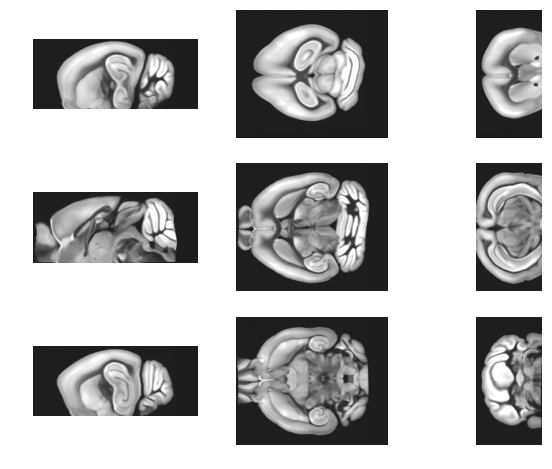


Step 1: alpha=0.02, beta=0.05, scale=0.125
	E, E_velocity, E_rate, E_image (E_image %), LearningRate
0.	-3.11289e+08, 18.7299, 0, -3.11289e+08 (99.6309%), 1.375000e-03
1.	-3.1223e+08, 41.9468, 0, -3.1223e+08 (99.5434%), 1.512500e-03
2.	-3.14014e+08, 72.8798, 0, -3.14014e+08 (99.3775%), 1.663750e-03
3.	-3.18592e+08, 101.487, 0, -3.18592e+08 (98.9519%), 1.830125e-03
4.	-3.2111e+08, 138.674, 0, -3.2111e+08 (98.7178%), 2.013138e-03
5.	-3.25067e+08, 149.568, 0, -3.25067e+08 (98.3499%), 1.107226e-03
6.	-3.25501e+08, 150.692, 0, -3.25501e+08 (98.3096%), 1.522435e-04
7.	-3.25856e+08, 150.749, 0, -3.25857e+08 (98.2765%), 2.093348e-05
8.	-3.25876e+08, 150.768, 0, -3.25876e+08 (98.2747%), 5.756708e-06
E = -3.25876e+08 (98.2747%)
Length = 13.965
Time = 155.422s (2.59037m)


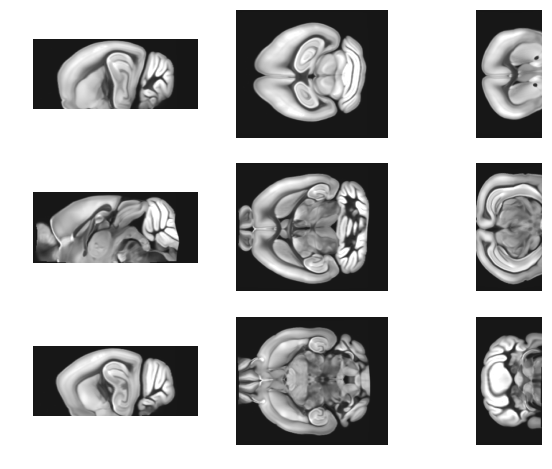


Step 2: alpha=0.02, beta=0.05, scale=0.25
	E, E_velocity, E_rate, E_image (E_image %), LearningRate
0.	-2.28533e+08, 1.56536, 0, -2.28533e+08 (99.9604%), 1.375000e-02
1.	-2.33353e+08, 3.92154, 0, -2.33353e+08 (99.5202%), 1.512500e-02
2.	-2.34711e+08, 7.77877, 0, -2.34711e+08 (99.3961%), 1.663750e-02
3.	-2.38376e+08, 13.3883, 0, -2.38376e+08 (99.0613%), 1.830125e-02
4.	-2.3846e+08, 13.8448, 0, -2.3846e+08 (99.0536%), 2.516422e-03
5.	-2.38791e+08, 14.3194, 0, -2.38791e+08 (99.0234%), 2.768064e-03
6.	-2.393e+08, 14.8648, 0, -2.393e+08 (98.9769%), 3.044870e-03
7.	-2.39352e+08, 15.6152, 0, -2.39352e+08 (98.9722%), 3.349358e-03
8.	-2.40109e+08, 16.4891, 0, -2.40109e+08 (98.903%), 3.684293e-03
9.	-2.40116e+08, 16.5018, 0, -2.40117e+08 (98.9023%), 6.332379e-05
10.	-2.40118e+08, 16.5035, 0, -2.40118e+08 (98.9022%), 8.707021e-06
11.	-2.40118e+08, 16.5038, 0, -2.40118e+08 (98.9022%), 1.197215e-06
12.	-2.40118e+08, 16.5039, 0, -2.40118e+08 (98.9022%), 6.584685e-07
13.	-2.40118e+08, 16.504, 0, -2.

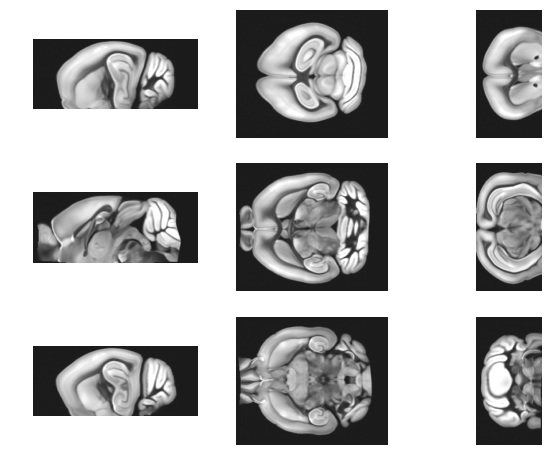


Step 3: alpha=0.02, beta=0.05, scale=0.5
	E, E_velocity, E_rate, E_image (E_image %), LearningRate
0.	-2.21685e+08, 0.130507, 0, -2.21685e+08 (99.8897%), 6.875000e-02
1.	-2.2308e+08, 0.841352, 0, -2.2308e+08 (99.7593%), 7.562500e-02
2.	-2.25393e+08, 1.50296, 0, -2.25393e+08 (99.5431%), 8.318750e-02
3.	-2.264e+08, 2.45132, 0, -2.264e+08 (99.4491%), 9.150625e-02
4.	-2.27355e+08, 3.56072, 0, -2.27355e+08 (99.3598%), 1.006569e-01
5.	-2.28664e+08, 5.13968, 0, -2.28664e+08 (99.2376%), 1.107226e-01
6.	-2.29762e+08, 6.78807, 0, -2.29762e+08 (99.1349%), 1.217948e-01
7.	-2.30531e+08, 8.58743, 0, -2.30531e+08 (99.063%), 1.339743e-01
8.	-2.30569e+08, 8.71421, 0, -2.30569e+08 (99.0595%), 9.210733e-03
9.	-2.3061e+08, 8.85053, 0, -2.3061e+08 (99.0557%), 1.013181e-02
10.	-2.30647e+08, 9.00259, 0, -2.30647e+08 (99.0522%), 1.114499e-02
11.	-2.30692e+08, 9.16963, 0, -2.30692e+08 (99.048%), 1.225949e-02
12.	-2.30726e+08, 9.35937, 0, -2.30726e+08 (99.0448%), 1.348543e-02
13.	-2.30767e+08, 9.56, 0, -2.3076

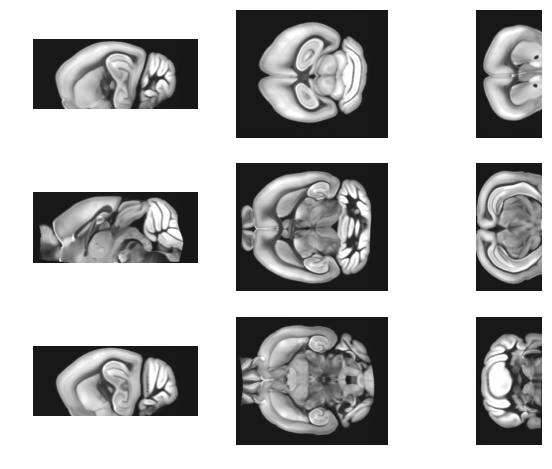


Step 4: alpha=0.02, beta=0.05, scale=1.0
	E, E_velocity, E_rate, E_image (E_image %), LearningRate
0.	-2.2841e+08, 11.532, 0, -2.2841e+08 (99.7389%), 5.500000e+00
1.	-2.29862e+08, 1.78169, 0, -2.29862e+08 (99.6022%), 7.562500e-01
2.	-2.29862e+08, 1.78168, 0, -2.29862e+08 (99.6022%), 1.586676e-06
3.	-2.29862e+08, 1.78168, 0, -2.29862e+08 (99.6022%), 4.363358e-07
4.	-2.29862e+08, 1.78168, 0, -2.29862e+08 (99.6022%), 5.999617e-08
5.	-2.29862e+08, 1.78168, 0, -2.29862e+08 (99.6022%), 8.249474e-09
6.	-2.29862e+08, 1.78168, 0, -2.29862e+08 (99.6022%), 1.417878e-10
E = -2.29862e+08 (99.6022%)
Length = 1.54389
Time = 2990.68s (49.8447m)


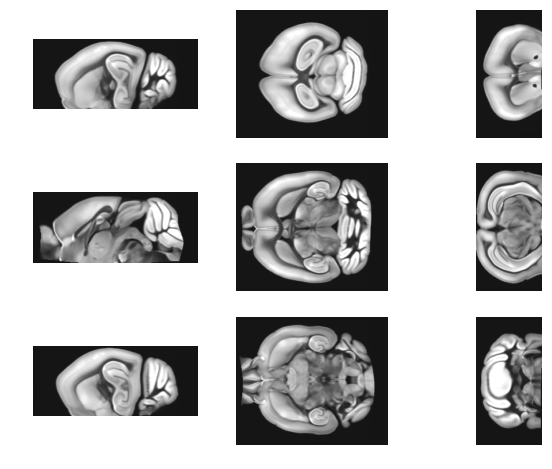

In [38]:
atlas_lddmm = registerer.register_lddmm(alpha_list=[0.02], 
                                        scale_list = [0.0625, 0.125, 0.25, 0.50, 1.0], 
                                        epsilon_list=[1e-3, 1e-2, 1e-1, 1e0, 1e1], sigma=1e-3, 
                                        use_mi=True, iterations=200, 
                                        verbose=True)

In [109]:
atlas_lddmm_c = ndreg.imgApplyField(registerer.source_affine, registerer.field, 
                                    size=registerer.target_reoriented.GetSize(), 
                                    spacing=registerer.target_reoriented.GetSpacing())

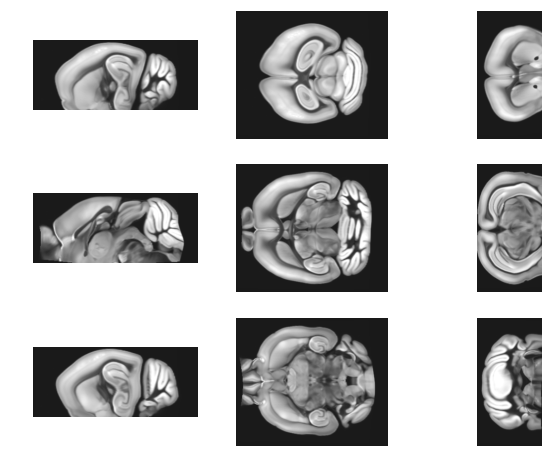

In [110]:
ndreg.imgShow(atlas_lddmm_c, vmax=1)

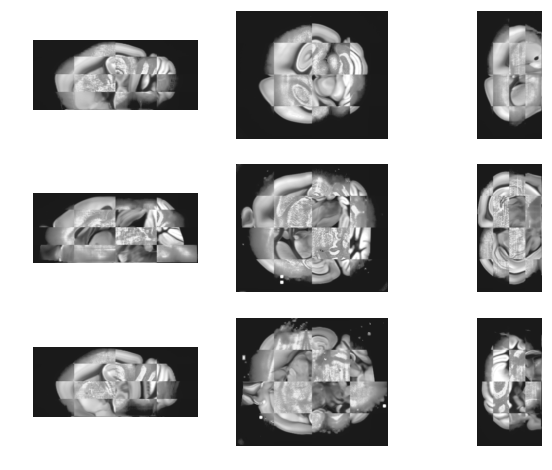

In [59]:
ndreg.imgShow(ndreg.imgChecker(registerer.target_reoriented, atlas_lddmm_c), vmax=1)

In [60]:
img.GetSize()

(270, 320, 137)

In [61]:
img.GetSpacing()

(0.041280000000000004, 0.041280000000000004, 0.041280000000000004)

In [117]:
atlas_lddmm_cr.GetSize()

(270, 320, 137)

In [118]:
atlas_lddmm_cr.GetSpacing()

(0.041280000000000004, 0.041280000000000004, 0.041280000000000004)

In [63]:
atlas_lddmm_cr = ndreg.imgReorient(atlas_lddmm_c, "PIR", "LPI")

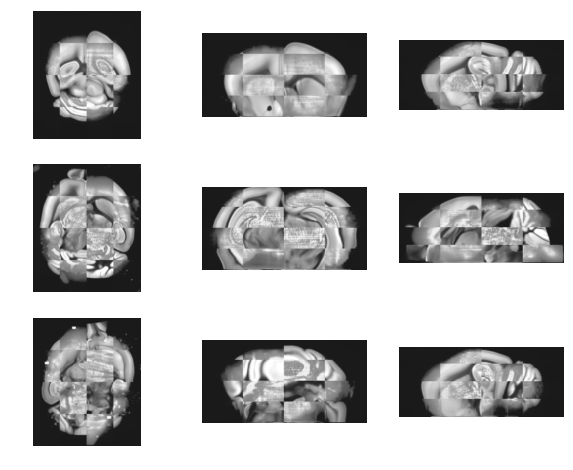

In [106]:
ndreg.imgShow(ndreg.imgChecker(registerer.target, atlas_lddmm_cr), vmax=1)

In [119]:
atlas_lddmm_cr.GetPixelIDTypeAsString()

'32-bit float'

In [120]:
img.GetPixelIDTypeAsString()

'16-bit unsigned integer'

In [97]:
registerer.source_affine.GetPixelIDTypeAsString()

'32-bit float'

In [99]:
tmp = sitk.GetArrayFromImage(atlas_lddmm_cr)

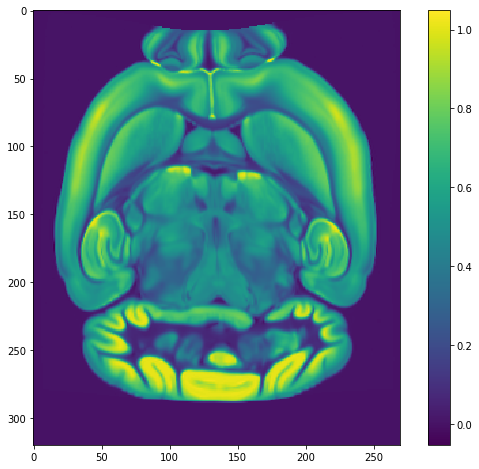

In [100]:
plt.imshow(tmp[80,:,:])
plt.colorbar()
plt.show()

In [101]:
tmp_n = (tmp - tmp.min())/(tmp.max() - tmp.min())

In [102]:
tmp_n *= (2.0**16 - 1)
len(np.unique(tmp_n.astype('uint16')))

56243

In [89]:
import skimage

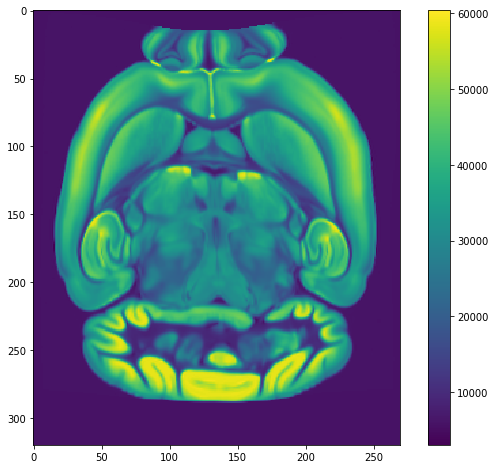

In [104]:
plt.imshow(tmp_n.astype('uint16')[80,:,:])
plt.colorbar()
plt.show()

In [114]:
registerer.target.GetSize()

(270, 320, 137)

In [115]:
registerer.target_reoriented.GetSpacing()

(0.041280000000000004, 0.041280000000000004, 0.041280000000000004)

In [116]:
atlas_lddmm_cr.GetSize()

(270, 320, 137)

In [113]:
tmp_n.shape

(137, 320, 270)

In [124]:
sitk.GetArrayFromImage(registerer.target).astype('uint16').shape

(137, 320, 270)

In [125]:
test_img = sitk.GetArrayFromImage(registerer.target).astype('uint16')

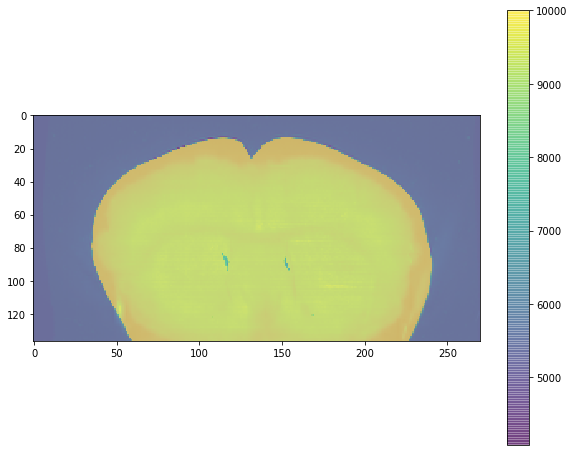

In [132]:
plt.imshow(test_img[:,80,:], vmax=10000, alpha=0.5)
plt.imshow(tmp_n.astype('uint16')[:,80,:], vmax=10000, alpha=0.5)
plt.colorbar()
plt.show()

In [105]:
ch_rsc = create_channel_resource(rmt, 'atlas', 'registrations', '170119_Insula_grCOMET_244_08-39-35_reg',
                                 type='image', base_resolution=0, sources=[], datatype='uint16', new_channel=True)
upload_to_boss(rmt, tmp_n.astype('uint16'), ch_rsc, resolution=0)

(0, [0, 270], [0, 320], [0, 16])
(0, [0, 270], [0, 320], [16, 32])
(0, [0, 270], [0, 320], [32, 48])
(0, [0, 270], [0, 320], [48, 64])
(0, [0, 270], [0, 320], [64, 80])
(0, [0, 270], [0, 320], [80, 96])
(0, [0, 270], [0, 320], [96, 112])
(0, [0, 270], [0, 320], [112, 128])
(0, [0, 270], [0, 320], [128, 137])


In [71]:
ch_rsc = create_channel_resource(rmt, '170119_Insula_grCOMET_244_08-39-35_res3', 'registrations', '170119_Insula_grCOMET_244_08-39-35_reg',
                                 type='image', base_resolution=0, sources=[], datatype='uint16', new_channel=True)
upload_to_boss(rmt, sitk.GetArrayFromImage(img).astype('uint16'), ch_rsc, resolution=0)

(0, [0, 270], [0, 320], [0, 16])
(0, [0, 270], [0, 320], [16, 32])
(0, [0, 270], [0, 320], [32, 48])
(0, [0, 270], [0, 320], [48, 64])
(0, [0, 270], [0, 320], [64, 80])
(0, [0, 270], [0, 320], [80, 96])
(0, [0, 270], [0, 320], [96, 112])
(0, [0, 270], [0, 320], [112, 128])
(0, [0, 270], [0, 320], [128, 137])


In [66]:
sitk.WriteImage(atlas_lddmm_cr, "atlas_to_{}_res_50_s_1e-3_a_02_mi.tif".format(exp))

### Perform LDDMM registration

In [47]:
from lddmm_image_3d import *

In [118]:
img_np = sitk.GetArrayFromImage(registerer.target_ds)

In [113]:
atlas_affine_np = sitk.GetArrayFromImage(atlas_affine)

In [114]:
spacing = 0.05 # mm

In [115]:
xa = np.arange(0, img_np.shape[2]) * spacing
ya = np.arange(0, img_np.shape[1]) * spacing
za = np.arange(0, img_np.shape[0]) * spacing
xt = np.arange(0, atlas_affine_np.shape[2]) * spacing
yt = np.arange(0, atlas_affine_np.shape[1]) * spacing
zt = np.arange(0, atlas_affine_np.shape[0]) * spacing

In [116]:
xA, yA, zA = np.meshgrid(xa, ya, za, indexing='ij')
xT, yT, zT = np.meshgrid(xt, yt, zt, indexing='ij')

In [117]:
xA.max()

5.6500000000000004

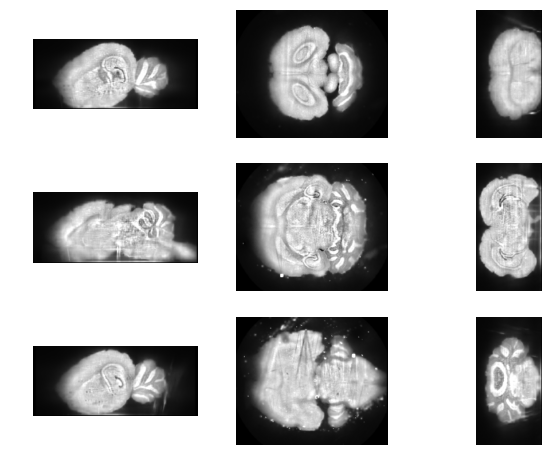

In [119]:
ndreg.imgShow(registerer.target_ds)

In [124]:
out = lddmm_image_3d(xA, yA, zA, atlas_affine_np, xT, yT, zT, img_np, sigmaI=0.1, sigmaR=1e-3, epsilon=2e4, niter=200, alpha=500)

MemoryError: 

## testing new params lddmm


Step 0: alpha=0.01, beta=0.05, scale=0.0625
	E, E_velocity, E_rate, E_image (E_image %), LearningRate
0.	-5.62066e+10, 26.1914, 0, -5.62066e+10 (98.171%), 6.713867e-07
1.	-5.79541e+10, 56.5996, 0, -5.79541e+10 (96.1549%), 7.385254e-07
2.	-5.8222e+10, 57.4667, 0, -5.8222e+10 (95.8458%), 1.015472e-07
3.	-5.83746e+10, 58.0212, 0, -5.83746e+10 (95.6697%), 5.585098e-08
4.	-5.84475e+10, 58.2428, 0, -5.84475e+10 (95.5857%), 3.071804e-08
5.	-5.85252e+10, 58.3522, 0, -5.85252e+10 (95.496%), 8.447461e-09
6.	-5.85254e+10, 58.4108, 0, -5.85254e+10 (95.4958%), 4.646104e-09
7.	-5.85361e+10, 58.4654, 0, -5.85361e+10 (95.4834%), 5.110714e-09
8.	-5.8552e+10, 58.5179, 0, -5.8552e+10 (95.4651%), 5.621785e-09
9.	-5.85749e+10, 58.5746, 0, -5.85749e+10 (95.4387%), 6.183964e-09
10.	-5.86219e+10, 58.6247, 0, -5.86219e+10 (95.3845%), 6.802360e-09
11.	-5.87478e+10, 58.6756, 0, -5.87478e+10 (95.2392%), 7.482596e-09
12.	-5.87825e+10, 58.7241, 0, -5.87825e+10 (95.1992%), 8.230856e-09
13.	-5.8834e+10, 58.8216, 0, 

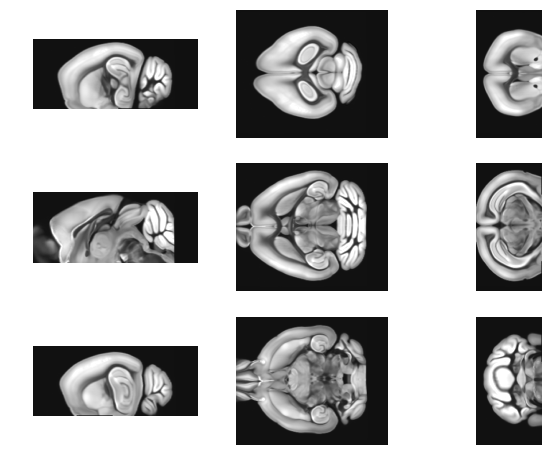


Step 1: alpha=0.01, beta=0.05, scale=0.125
	E, E_velocity, E_rate, E_image (E_image %), LearningRate
0.	-3.09158e+10, 0.82563, 0, -3.09158e+10 (99.809%), 1.678467e-06
1.	-3.14215e+10, 1.58696, 0, -3.14215e+10 (99.3389%), 1.846313e-06
2.	-3.16427e+10, 2.80233, 0, -3.16427e+10 (99.1334%), 2.030945e-06
3.	-3.17041e+10, 4.49441, 0, -3.17041e+10 (99.0762%), 2.234039e-06
4.	-3.19305e+10, 6.5683, 0, -3.19305e+10 (98.8658%), 2.457443e-06
5.	-3.21023e+10, 7.44154, 0, -3.21023e+10 (98.7062%), 1.351594e-06
6.	-3.21741e+10, 7.85814, 0, -3.21741e+10 (98.6393%), 7.433766e-07
7.	-3.21975e+10, 7.95169, 0, -3.21975e+10 (98.6176%), 2.044286e-07
8.	-3.22689e+10, 8.07439, 0, -3.22689e+10 (98.5513%), 2.248714e-07
E = -3.22689e+10 (98.5513%)
Length = 2.83319
Time = 156.378s (2.60629m)


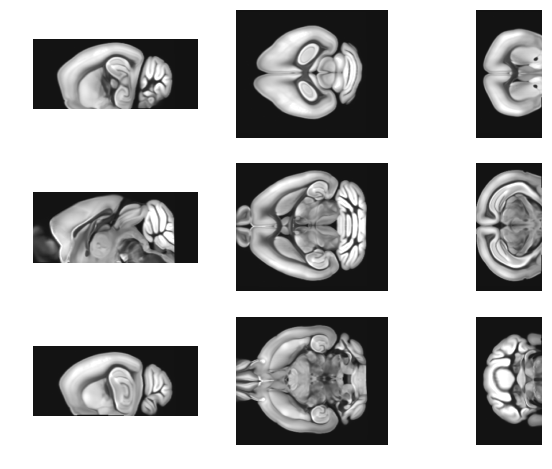


Step 2: alpha=0.01, beta=0.05, scale=0.25
	E, E_velocity, E_rate, E_image (E_image %), LearningRate
0.	-2.2233e+10, 16.3458, 0, -2.2233e+10 (99.7539%), 2.685547e-04
1.	-2.32289e+10, 37.9381, 0, -2.32289e+10 (98.8512%), 2.954102e-04
2.	-2.39397e+10, 75.5359, 0, -2.39397e+10 (98.2069%), 3.249512e-04
3.	-2.44901e+10, 123.088, 0, -2.44901e+10 (97.708%), 3.574463e-04
4.	-2.50729e+10, 183.464, 0, -2.50729e+10 (97.1798%), 3.931909e-04
5.	-2.56408e+10, 252.04, 0, -2.56408e+10 (96.665%), 4.325100e-04
6.	-2.5903e+10, 336.879, 0, -2.5903e+10 (96.4273%), 4.757610e-04
7.	-2.68823e+10, 450.905, 0, -2.68823e+10 (95.5397%), 5.233371e-04
8.	-2.72593e+10, 522.348, 0, -2.72593e+10 (95.198%), 2.878354e-04
9.	-2.7728e+10, 583.144, 0, -2.7728e+10 (94.7731%), 3.166190e-04
10.	-2.78086e+10, 619.089, 0, -2.78086e+10 (94.7001%), 1.741404e-04
11.	-2.81691e+10, 654.561, 0, -2.81691e+10 (94.3733%), 1.915545e-04
12.	-2.83405e+10, 710.347, 0, -2.83405e+10 (94.2179%), 2.107099e-04
13.	-2.83769e+10, 734.184, 0, -2.83

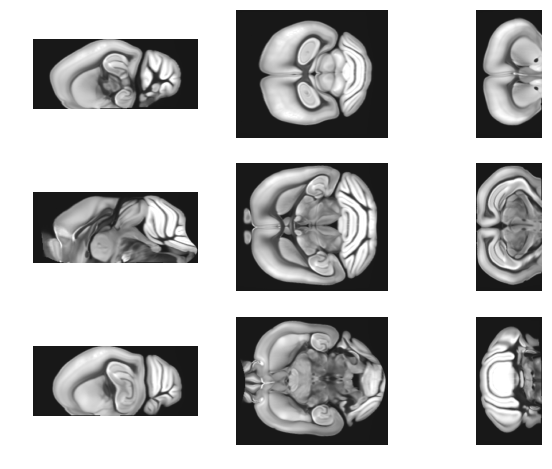

In [135]:
atlas_lddmm = registerer.register_lddmm(alpha_list=[0.01], 
                                        scale_list = [0.0625, 0.125, 0.25], 
                                        epsilon_list=[1e-2, 1e-1, 1e0], sigma=1e-4, 
                                        use_mi=True, iterations=200, 
                                        verbose=True)

In [136]:
atlas_lddmm_c = ndreg.imgApplyField(registerer.source_affine, registerer.field, 
                                    size=registerer.target_reoriented.GetSize(), 
                                    spacing=registerer.target_reoriented.GetSpacing())

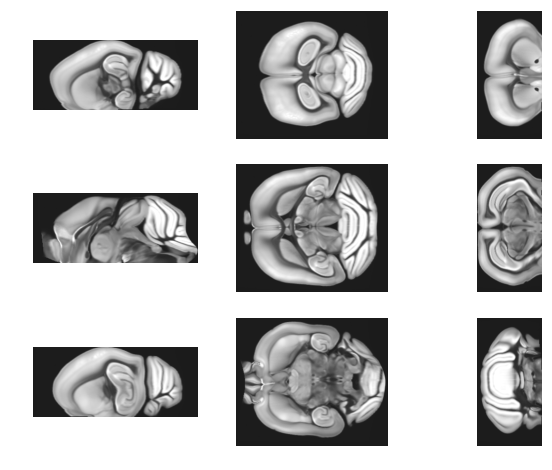

In [137]:
ndreg.imgShow(atlas_lddmm_c, vmax=1)

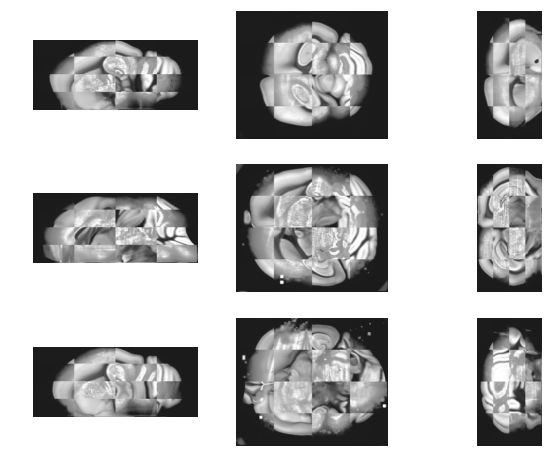

In [138]:
ndreg.imgShow(ndreg.imgChecker(registerer.target_reoriented, atlas_lddmm_c), vmax=1)